# Ideal Processing Pipeline for Consistent CTCF in Fluorescence Microscopy

Here's a comprehensive pipeline for analyzing fluorescence microscopy images with consistent CTCF measurement across different conditions and microscopes:



In [1]:
## Import necessary libraries
import time, os, sys
import traceback
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import tifffile as tiff
from PIL import Image

import numpy as np
import pandas as pd
from skimage import measure, draw, exposure
from skimage.transform import resize
from skimage.segmentation import find_boundaries

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import scipy.stats

from tqdm import tqdm
import torch
import glob
import gc

mpl.rcParams['figure.dpi'] = 200

from AutoImgUtils import * 

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics, denoise
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:42:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0
Fri Apr 11 01:57:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN RTX             WDDM  |   00000000:81:00.0 Off |                  N/A |
| 41% 

## Function Definitions

### Visualization functions
Here the visualization functions are defined, that can be used to save plots regarding the background substraction as well as the segmentation results for quality control

In [ ]:
def visualize_background_mask(channel_image, bg_model, output_path, n_components=3, enhance_contrast=True):
    """Visualize background mask from GMM model with distribution plots"""
    # Create figure with 4 subplots (2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Enhance contrast for visualization if requested
    if enhance_contrast:
        # Use percentile-based contrast stretching (robust to outliers)
        p_low, p_high = 2, 98  # Percentiles for contrast stretching
        display_img = exposure.rescale_intensity(
            channel_image, 
            in_range=tuple(np.percentile(channel_image, (p_low, p_high))),
            out_range='dtype'
        )
    else:
        display_img = channel_image
    
    # Original image with enhanced contrast
    axes[0, 0].imshow(display_img, cmap='gray')
    axes[0, 0].set_title('Original Channel' + (' (Contrast Enhanced)' if enhance_contrast else ''))
    plt.colorbar(axes[0, 0].get_images()[0], ax=axes[0, 0])
    
    # Background mask
    axes[0, 1].imshow(bg_model['mask'], cmap='hot')
    axes[0, 1].set_title(f'Background Mask\nMean: {bg_model["mean"]:.2f}, Std: {bg_model["std"]:.2f}')
    plt.colorbar(axes[0, 1].get_images()[0], ax=axes[0, 1])
    
    # Original with background highlighted
    norm_img = (channel_image - np.min(channel_image)) / (np.max(channel_image) - np.min(channel_image))
    rgb_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
    
    # Highlight background in red
    rgb_img[:,:,0][bg_model['mask']] = 1.0  # Set red high for background
    rgb_img[:,:,1][bg_model['mask']] = 0.0  # Set green low for background
    rgb_img[:,:,2][bg_model['mask']] = 0.0  # Set blue low for background
    
    axes[1, 0].imshow(rgb_img)
    axes[1, 0].set_title('Background Regions (Red)')
    
    # Plot intensity histogram with GMM distributions
    # Modified to use component parameters instead of GMM object
    if 'component_weights' in bg_model and 'component_means' in bg_model and 'component_covs' in bg_model:
        flat_img = channel_image.flatten()
        
        # Plot histogram
        hist_range = (np.min(flat_img), np.max(flat_img))
        n_bins = 100
        axes[1, 1].hist(flat_img, bins=n_bins, range=hist_range, density=True, 
                       alpha=0.6, color='gray', label='Pixel Intensity')
        
        # Create x values for plotting GMM curves
        x = np.linspace(hist_range[0], hist_range[1], 1000)
        
        # Plot the individual components
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        bg_component = bg_model['bg_component']
        
        for i in range(len(bg_model['component_means'])):
            # Calculate component density
            weight = bg_model['component_weights'][i]
            mean = bg_model['component_means'][i]
            std = np.sqrt(bg_model['component_covs'][i])
            
            # Create a normal distribution for this component
            y = weight * scipy.stats.norm.pdf(x, mean, std)
            
            # Plot with higher alpha for background component
            alpha = 0.8 if i == bg_component else 0.5
            label = f"Background (μ={mean:.1f})" if i == bg_component else f"Component {i+1} (μ={mean:.1f})"
            axes[1, 1].plot(x, y, color=colors[i % len(colors)], 
                         alpha=alpha, linewidth=2, label=label)
            
        axes[1, 1].set_title('Pixel Intensity Distribution')
        axes[1, 1].set_xlabel('Pixel Value')
        axes[1, 1].set_xscale('log')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].legend()
        
        del flat_img, hist_range, n_bins, x
        
    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    plt.close('all')

    del display_img, rgb_img

def save_segmentation_qc_images(image, cell_masks, output_dir, img_name, config=None):
    """
    Save quality control images showing zoomed-in regions of segmentation results
    
    Parameters:
    - image: Multi-channel image array
    - cell_masks: Integer mask with cell labels
    - output_dir: Directory to save output images
    - img_name: Base name of the image being processed
    - config: Configuration dictionary with QC settings
    """
    if config is None:
        config = {}
    
    # Extract configuration
    num_regions = config.get('qc_num_regions', 3)
    region_size = config.get('qc_region_size', 400)
    channels_to_show = config.get('qc_channels', list(range(image.shape[-1])))
    
    # Get cell properties and centroids
    props = measure.regionprops(cell_masks)
    
    if len(props) == 0:
        print("No cells detected for QC visualization")
        return
    
    # Create QC directory
    qc_dir = os.path.join(output_dir, "qc_regions")
    os.makedirs(qc_dir, exist_ok=True)
    
    # Select cell regions to display
    # Strategy 1: Select cells with most area (likely most interesting)
    props_sorted_by_area = sorted(props, key=lambda x: x.area, reverse=True)
    
    # Select some large cells and some random cells for diversity
    selected_props = props_sorted_by_area[:min(num_regions, len(props))]
    
    # Add some random cells from the remaining population if available
    remaining_props = props_sorted_by_area[min(num_regions, len(props)):]
    if remaining_props and len(remaining_props) > num_regions:
        random_indices = np.random.choice(len(remaining_props), 
                                         min(num_regions, len(remaining_props)), 
                                         replace=False)
        selected_props.extend([remaining_props[i] for i in random_indices])
    
    # Process each selected region
    for i, prop in enumerate(selected_props):
        # Get centroid and bounds for region extraction
        y, x = int(prop.centroid[0]), int(prop.centroid[1])
        
        # Define boundaries ensuring they're within image bounds
        h, w = image.shape[0:2]
        half_size = region_size // 2
        
        y1 = max(0, y - half_size)
        y2 = min(h, y + half_size)
        x1 = max(0, x - half_size)
        x2 = min(w, x + half_size)
        
        # Extract region masks
        region_mask = cell_masks[y1:y2, x1:x2]
        
        # Create figure with rows for each channel and columns for (original, mask overlay)
        num_channels = len(channels_to_show)
        fig, axes = plt.subplots(num_channels, 2, figsize=(12, 4*num_channels))
        
        if num_channels == 1:
            axes = np.array([axes])  # Make it 2D for consistent indexing
            
        region_name = f"region_{i+1}_cell_{prop.label}"
        fig.suptitle(f"Region {i+1}: Cell {prop.label} (Area: {prop.area}px)")
        
        # Process each channel
        for ch_idx, ch in enumerate(channels_to_show):
            if ch < image.shape[-1]:  # Ensure channel exists
                # Extract region for this channel
                region_img = image[y1:y2, x1:x2, ch]
                
                # Normalize for display
                p2, p98 = np.percentile(region_img, (2, 98))
                region_img_norm = np.clip((region_img - p2) / (p98 - p2) * 255, 0, 255).astype(np.uint8)
                
                # Display original channel
                axes[ch_idx, 0].imshow(region_img_norm, cmap='gray')
                axes[ch_idx, 0].set_title(f"Channel {ch+1}")
                axes[ch_idx, 0].axis('off')
                
                # Create mask overlay
                mask_overlay = np.zeros((*region_img.shape, 4), dtype=np.uint8)
                
                # Unique colors for each cell in the region
                unique_labels = np.unique(region_mask)
                unique_labels = unique_labels[unique_labels > 0]  # Skip background
                
                # Create colorful mask overlay
                for label in unique_labels:
                    color = np.array(plt.cm.tab10(label % 10)) * 255
                    mask_overlay[region_mask == label] = [*color[:3], 128]  # Semi-transparent
                    
                # Show mask overlaid on original image
                axes[ch_idx, 1].imshow(region_img_norm, cmap='gray')
                axes[ch_idx, 1].imshow(mask_overlay)
                axes[ch_idx, 1].set_title(f"Channel {ch+1} with segmentation")
                axes[ch_idx, 1].axis('off')
        
        # Adjust layout and save
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Make room for suptitle
        region_filename = os.path.join(qc_dir, f"{os.path.splitext(img_name)[0]}_{region_name}.png")
        plt.savefig(region_filename, dpi=150)
        plt.close(fig)
    
    print(f"Saved {len(selected_props)} QC region visualizations to {qc_dir}")

def create_visualization(image, masks, measurements, output_path, debug=False):
    """
    Create multi-panel visualization for QC with optimized memory usage and enhanced contrast
    
    Parameters:
    - image: Multi-channel image
    - masks: Cell segmentation masks
    - measurements: Cell measurements
    - output_path: Where to save the visualization
    - debug: Enable detailed timing and progress tracking
    """
    try:
        if debug:
            start_time = time.time()
            print(f"Starting visualization for {output_path}...")
        
        # Force garbage collection before starting
        gc.collect()
        
        # Get image dimensions and channel count
        h, w, n_channels = image.shape
        
        # Calculate reasonable figure size to avoid excessive memory usage
        max_dim = 2000  # Maximum dimension in pixels
        scale_factor = min(1.0, max_dim / max(h, w))
        
        # Create figure without displaying (reduces memory usage)
        dpi = 300  # Mantain good quality
        fig_width = (n_channels + 1) * 4  # 4 inches per panel
        fig_height = 4  # Fixed height
        
        # Use Figure directly instead of pyplot to avoid memory leaks
        fig = Figure(figsize=(fig_width, fig_height), dpi=dpi)
        canvas = FigureCanvasAgg(fig)
        
        if debug:
            print(f"Created figure with size {fig_width}x{fig_height} inches at {dpi} DPI")
            print(f"Processing {n_channels} channels and {len(measurements)} cells")
        
        # Create subplot grid
        grid = fig.add_gridspec(1, n_channels + 1)
        
        # Plot segmentation mask (first panel) with enhanced contrast
        if debug:
            print("Rendering segmentation mask...")
        
        ax = fig.add_subplot(grid[0, 0])
        
        # Convert mask to float for better visualization
        mask_display = (masks > 0).astype(float)
        # Apply contrast enhancement to make it more visible
        mask_display = exposure.equalize_adapthist(mask_display)
        ax.imshow(mask_display, cmap='viridis')  # Use viridis for better contrast
        ax.set_title('Cell Segmentation (Enhanced)')
        ax.axis('off')  # Turn off axes to save memory
        
        # Only add labels for a subset of cells
        if len(measurements) > 0:
            if debug:
                print("Adding cell labels...")
            # Select a random subset of 50 cells or fewer if there are less than 50
            num_labels = min(50, len(measurements))
            # Use numpy's random choice if measurements is a list, otherwise select first num_labels
            if isinstance(measurements, list):
                indices = np.random.choice(len(measurements), num_labels, replace=False)
                label_subset = [measurements[i] for i in indices]
            else:
                label_subset = measurements[:num_labels]
                
            for cell in label_subset:
                y, x = cell['centroid']
                ax.text(x, y, str(cell['label']), color='red', fontsize=5)
        
        # Process channels with progress tracking
        channel_range = range(n_channels)
        if debug:
            from tqdm import tqdm
            channel_range = tqdm(channel_range, desc="Processing channels")
        
        for ch_idx, ch in enumerate(channel_range):
            if debug:
                ch_start = time.time()
                
            # Create subplot for this channel
            ax = fig.add_subplot(grid[0, ch_idx + 1])
            
            # Get channel data and apply adaptive contrast enhancement
            channel_data = image[:,:,ch].copy()  # Make a copy to avoid modifying original
            
            # Adaptive histogram equalization - best for visualizing local features
            enhanced_data = exposure.equalize_adapthist(channel_data, clip_limit=0.03)
            
            # Display the image
            ax.imshow(enhanced_data, cmap='hot')
            ax.set_title(f'Channel {ch+1} (Enhanced)')
            ax.axis('off')  # Turn off axes to save memory
            
            # Show cell boundaries efficiently
            boundaries = find_boundaries(masks > 0)
            ax.imshow(boundaries, alpha=0.3, cmap='cool')
            
            # Free memory
            del channel_data
            del enhanced_data
            del boundaries
            
            if debug:
                print(f"  Channel {ch+1} rendered in {time.time() - ch_start:.2f}s")
        
        # Adjust layout and save
        if debug:
            print("Saving figure...")
            save_start = time.time()
            
        fig.tight_layout()
        fig.savefig(output_path, bbox_inches='tight')
        
        # Clean up matplotlib resources explicitly
        fig.clf()
        canvas.renderer.clear()
        del fig
        del canvas
        
        # Force garbage collection
        gc.collect()
        
        if debug:
            print(f"Visualization saved in {time.time() - save_start:.2f}s")
            print(f"Total visualization time: {time.time() - start_time:.2f}s")
            
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        traceback.print_exc()
        
        # Ensure cleanup even on error
        if 'fig' in locals():
            fig.clf()
            del fig
        if 'canvas' in locals():
            canvas.renderer.clear()
            del canvas
        gc.collect()

### Background substraction and CellPose based Segmentation Functions
Here the main functions for background substraction and cell segmentation based on de cyto3 model are defined

In [ ]:
#Functions for File processing and Directory Handling 
def process_experiments_batch(main_directory, config):
    """
    Process all experiments in the main directory with improved memory management
    """
    # Create results directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = os.path.join(main_directory, f"CTCF_Analysis_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)
    
    # Find all experiment folders
    experiment_folders = [f.path for f in os.scandir(main_directory) if f.is_dir() 
                         and not f.name.startswith('.') and not "CTCF_Analysis" in f.name]
    
    # Process each experiment folder
    for experiment_folder in experiment_folders:
        exp_name = os.path.basename(experiment_folder)
        print(f"\nProcessing experiment: {exp_name}")
        
        # Create experiment results folder
        exp_results_dir = os.path.join(results_dir, exp_name)
        os.makedirs(exp_results_dir, exist_ok=True)
        
        # Process all images in experiment folder
        image_files = [f for f in os.listdir(experiment_folder) 
                      if f.endswith(('.tif', '.tiff')) and not f.startswith('.')]
        
        # Create a DataFrame for experiment results instead of list to save memory
        exp_results_df = pd.DataFrame()
        
        for image_file in image_files:
            # Full image processing pipeline for each image
            img_result = process_single_image(
                os.path.join(experiment_folder, image_file),
                exp_results_dir,
                config
            )
            
            # Append result to DataFrame directly
            exp_results_df = pd.concat([exp_results_df, pd.DataFrame([img_result])], ignore_index=True)
            
            # Force garbage collection after each image
            gc.collect()
        
        # Save experiment results
        exp_results_df.to_csv(os.path.join(exp_results_dir, f"{exp_name}_results.csv"), index=False)
        
        # Write to batch summary file incrementally instead of keeping in memory
        batch_summary_path = os.path.join(results_dir, "batch_summary.csv")
        if os.path.exists(batch_summary_path):
            exp_results_df.to_csv(batch_summary_path, mode='a', header=False, index=False)
        else:
            exp_results_df.to_csv(batch_summary_path, index=False)
        
        # Clear DataFrame to free memory
        del exp_results_df
        gc.collect()
    
    print(f"All experiments processed. Results saved to: {results_dir}")
    return results_dir

def process_single_image(image_path, output_dir, config):
    """Process a single fluorescence microscopy image with improved memory management"""
    try:
        # Load image and normalize channels
        image = tiff.imread(image_path)
        img_name = os.path.basename(image_path)
        img_base = os.path.splitext(img_name)[0]

        print(f"\nProcessing image: {img_name}")

        # Extract debug flag from config
        debug = config.get('debug', False)
        
        # Move the shortest axis (channels) to the last index
        shortest_axis = np.argmin(image.shape)
        image = np.moveaxis(image, shortest_axis, -1)
        
        # Extract configuration
        channels_of_interest = config.get('channels_of_interest', list(range(image.shape[-1])))
        
        # 1. BACKGROUND ESTIMATION USING GMM
        print("Estimating background using GMM...")
        bg_models = {}
        for ch in tqdm(range(image.shape[-1]), desc="Background estimation", leave=False):
            # Process one channel at a time to reduce memory usage
            channel_data = image[:,:,ch].copy()  # Make a copy to avoid reference issues
            bg_models[ch] = estimate_background(channel_data,config)
            
            # Save background mask visualization if needed
            if config.get('visualize_bg', True):
                visualize_background_mask(channel_data, bg_models[ch], 
                                         os.path.join(output_dir, f"{img_base}_bg_mask_ch{ch+1}.png"))
                plt.close('all')  # Ensure all plots are closed
            
            # Remove channel data from memory
            del channel_data
        
        print("Background estimation complete.")
        
        # 2. CELL SEGMENTATION USING CELLPOSE
        cell_masks = segment_cells_with_downsampling(image, config, bg_models)
        
        # 3. MEASURE CTCF FOR EACH CELL AND CHANNEL
        cell_measurements = measure_cells(image, cell_masks, bg_models, config)
        
        # Store key results in a DataFrame and save immediately
        cell_df = pd.DataFrame([
            {
                'image': img_name,
                'cell_id': i,
                'area': cell['area'],
                **{f'channel_{ch+1}_ctcf': cell['ctcf'][ch] for ch in channels_of_interest},
                **{f'channel_{ch+1}_mean': cell['mean'][ch] for ch in channels_of_interest},
                'centroid_x': cell['centroid'][0],
                'centroid_y': cell['centroid'][1]
            }
            for i, cell in enumerate(cell_measurements)
        ])
        cell_df.to_csv(os.path.join(output_dir, f"{img_base}_cells.csv"), index=False)
        
        # 4. GENERATE VISUALIZATIONS - do this after saving measurements to free memory
        if debug:
            print(f"Starting visualization with debug mode...")
        if config.get('visualize_segmentation', True):
            create_visualization(image, cell_masks, cell_measurements, 
                                os.path.join(output_dir, f"{img_name}_analysis.png"),
                                debug=debug)
            
            # Explicitly close all plots and collect garbage
            plt.close('all')
        
        if config.get('save_qc_regions', True):
            save_segmentation_qc_images(
                image, 
                cell_masks, 
                output_dir, 
                img_name, 
                config
            )
            
        gc.collect()
        
        # 5. CLEANUP AND RETURN RESULTS
        # Create a minimal results dictionary with just the summary stats
        results = {
            'image_name': img_name,
            'total_cells': len(cell_measurements),
            'image_path': image_path,
        }
        
        # Add summarized measurements
        for ch in channels_of_interest:
            ch_ctcf = [cell['ctcf'][ch] for cell in cell_measurements]
            results[f'channel_{ch+1}_mean_ctcf'] = np.mean(ch_ctcf)
            results[f'channel_{ch+1}_median_ctcf'] = np.median(ch_ctcf)
            results[f'channel_{ch+1}_std_ctcf'] = np.std(ch_ctcf)
            
        # Clean up large objects
        del image, cell_masks, cell_measurements, bg_models, cell_df
        gc.collect()
        
        return results
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        traceback.print_exc()
        gc.collect()
        return {'image_name': os.path.basename(image_path), 'error': str(e), 'total_cells': 0}

def resample_image(image, scale_factor=0.5):
    """Resample image by the given scale factor"""
    
    # Get original dimensions
    h, w, c = image.shape
    
    # Calculate new dimensions
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    
    # Resize image
    resized = resize(image, (new_h, new_w, c), preserve_range=True, anti_aliasing=True)
    
    return resized.astype(image.dtype)

def check_gpu_availability():
    """Check if GPU is available for processing"""
    if torch.cuda.is_available():
        return True
    else:
        return False

def estimate_background(channel_image, config):
    """
    Select appropriate background estimation method based on configuration
    
    Parameters:
    - channel_image: 2D array with image channel
    - config: Configuration dictionary with parameters
    
    Returns:
    - bg_model: Background model dict with estimation results
    """
    n_components = config.get('bg_components', 3)
    
    # Check if GPU should be used
    use_gpu = config.get('use_gpu', True) 
    if use_gpu and config.get('auto_detect_gpu', True):
        use_gpu = check_gpu_availability()
        
    # Select appropriate implementation
    if use_gpu:
        try:
            return fast_estimate_background_gmm_gpu(channel_image, n_components)
        except Exception as e:
            print(f"GPU background estimation failed: {str(e)}. Falling back to CPU.")
            return fast_estimate_background_gmm(channel_image, n_components)
    else:
        return fast_estimate_background_gmm(channel_image, n_components)

def fast_estimate_background_gmm_gpu(channel_image, n_components=3, max_iter=100, tol=1e-3):
    """
    Fully GPU-based Gaussian Mixture Model for background estimation
    
    Parameters:
    - channel_image: 2D numpy array with image channel
    - n_components: Number of components
    - max_iter: Maximum EM iterations
    - tol: Convergence tolerance
    """
    try: 
        device = torch.device('cuda')
    
        # Transfer to GPU once
        flat_img = torch.from_numpy(channel_image.flatten()).float().to(device).reshape(-1, 1)
        n_samples = flat_img.shape[0]
        
        # Sample if necessary (for large images)
        if n_samples > 1000000:
            indices = torch.randperm(n_samples, device=device)[:500000]
            sample_data = flat_img[indices]
        else:
            sample_data = flat_img
            
        # Initialize means with k-means++
        min_val, max_val = sample_data.min(), sample_data.max()
        
        # First mean is random
        idx = torch.randint(0, sample_data.shape[0], (1,), device=device)
        means = [sample_data[idx]]
        
        # Select remaining means with k-means++ strategy
        for _ in range(1, n_components):
            # Calculate distances to closest existing mean
            dists = torch.cat([torch.norm(sample_data - mean, dim=1).unsqueeze(1) for mean in means], dim=1)
            min_dists, _ = torch.min(dists, dim=1)
            
            # Sample proportional to squared distance
            probs = min_dists ** 2
            probs /= probs.sum()
            idx = torch.multinomial(probs, 1)
            means.append(sample_data[idx])
        
        # Stack means into tensor
        means = torch.cat(means, dim=0)
        
        # Initialize covariances and weights
        data_var = torch.var(sample_data)
        covs = torch.ones(n_components, device=device) * data_var
        weights = torch.ones(n_components, device=device) / n_components
        
        # Process in memory-efficient batches
        batch_size = 10000  # Adjust based on your GPU memory
            
        # EM algorithm
        log_likelihood = None
        for iteration in range(max_iter):
            # Prepare accumulators for sufficient statistics
            N_k = torch.zeros(n_components, device=device)
            mean_numerators = torch.zeros(n_components, 1, device=device)
            cov_numerators = torch.zeros(n_components, device=device)
            
            # Compute log_likelihood in batches
            total_log_resp_sum = 0.0
            
            # Process in batches
            for batch_start in range(0, flat_img.shape[0], batch_size):
                batch_end = min(batch_start + batch_size, flat_img.shape[0])
                batch_data = flat_img[batch_start:batch_end]
                
                # Create batch responsibility matrix
                batch_resp = torch.zeros(batch_end-batch_start, n_components, device=device)
                
                # E-step for this batch
                for k in range(n_components):
                    # Multivariate normal PDF (1D case)
                    diff = batch_data - means[k]
                    exponent = -0.5 * (diff ** 2) / covs[k]
                    norm_const = 1.0 / torch.sqrt(2 * torch.pi * covs[k])
                    batch_resp[:, k] = weights[k] * norm_const * torch.exp(exponent).squeeze()
                
                # Normalize responsibilities
                resp_sum = torch.sum(batch_resp, dim=1, keepdim=True)
                total_log_resp_sum += torch.sum(torch.log(resp_sum)).item()
                batch_resp = batch_resp / resp_sum
                
                # Update sufficient statistics
                for k in range(n_components):
                    resp_k = batch_resp[:, k].unsqueeze(1)
                    N_k[k] += torch.sum(resp_k)
                    mean_numerators[k] += torch.sum(resp_k * batch_data, dim=0)
                    diff = batch_data - means[k]
                    cov_numerators[k] += torch.sum(resp_k * (diff ** 2))
                
                # Clear batch data from GPU memory
                del batch_data, batch_resp, resp_sum
            
            # Calculate log-likelihood and check convergence
            new_log_likelihood = total_log_resp_sum / flat_img.shape[0]
            if log_likelihood is not None and abs(new_log_likelihood - log_likelihood) < tol:
                break
            log_likelihood = new_log_likelihood
            
            # M-step: Update parameters
            weights = N_k / flat_img.shape[0]
            
            # Update means and covariances
            for k in range(n_components):
                if N_k[k] > 1e-10:  # Avoid division by zero
                    means[k] = mean_numerators[k] / N_k[k]
                    covs[k] = cov_numerators[k] / N_k[k]
                    covs[k] = torch.clamp(covs[k], min=1e-6)  # Avoid singularity
    
        # Final prediction using batches
        pixel_labels = torch.zeros(flat_img.shape[0], dtype=torch.int64, device=device)
        
        for batch_start in range(0, flat_img.shape[0], batch_size):
            batch_end = min(batch_start + batch_size, flat_img.shape[0])
            batch_data = flat_img[batch_start:batch_end]
            
            # Calculate log probabilities for each component
            batch_log_probs = torch.zeros(batch_end-batch_start, n_components, device=device)
            
            for k in range(n_components):
                diff = batch_data - means[k]
                log_prob = -0.5 * (diff ** 2) / covs[k]
                log_prob -= 0.5 * torch.log(2 * torch.pi * covs[k])
                log_prob += torch.log(weights[k])
                batch_log_probs[:, k] = log_prob.squeeze()
            
            # Assign most likely component
            _, batch_labels = torch.max(batch_log_probs, dim=1)
            pixel_labels[batch_start:batch_end] = batch_labels
            
            # Free memory
            del batch_data, batch_log_probs, batch_labels

        # Find background component (lowest mean)
        bg_component = torch.argmin(means.squeeze()).item()
        bg_mean = means[bg_component].item()
        bg_std = torch.sqrt(covs[bg_component]).item()
        
        # Create background mask
        bg_mask = (pixel_labels == bg_component).reshape(channel_image.shape)
        
        results = {
            'mean': bg_mean,
            'std': bg_std,
            'mask': bg_mask.cpu().numpy(),
            'bg_percentage': torch.sum(bg_mask).float().item() / bg_mask.numel() * 100,
            'component_means': means.cpu().numpy(),
            'component_weights': weights.cpu().numpy(),
            'component_covs': covs.cpu().numpy(),
            'n_components': n_components,
            'bg_component': bg_component
        }
        
        return results
    
    except Exception as e:
        print(f"Error in GMM background estimation: {str(e)}")
        traceback.print_exc()
        # Return fallback values
        return {'mean': 0, 'std': 0, 'mask': np.zeros_like(channel_image, dtype=bool)}

def fast_estimate_background_gmm(channel_image, n_components=3, sample_ratio=0.1, 
                                max_iter=100, adaptive=False, max_components=6):
    """
    Fast background estimation using GMM with optional adaptive component selection
    """
    try:
        # Flatten image
        flat_img = channel_image.flatten()
        
        # Downsample by random sampling
        n_samples = max(10000, int(sample_ratio * flat_img.size))
        indices = np.random.choice(flat_img.size, size=n_samples, replace=False)
        sample_data = flat_img[indices].reshape(-1, 1)
        
        # Select GMM model - adaptive or fixed
        if adaptive:
            bic_scores = []
            models = []
            
            # Try different numbers of components
            for n in range(1, max_components + 1):
                # Initialize with K-means for faster convergence
                kmeans = KMeans(n_clusters=n, n_init=1, max_iter=100)
                kmeans.fit(sample_data)
                
                # Configure and fit GMM
                gmm = GaussianMixture(
                    n_components=n, 
                    random_state=42,
                    n_init=1, 
                    max_iter=max_iter,
                    tol=1e-3,
                    means_init=kmeans.cluster_centers_
                )
                
                gmm.fit(sample_data)
                bic_scores.append(gmm.bic(sample_data))
                models.append(gmm)
                
                del kmeans
                
            # Select model with lowest BIC score
            best_idx = np.argmin(bic_scores)
            gmm = models[best_idx]
            n_components = models[best_idx].n_components
            print(f"Adaptive GMM selected {n_components} components with BIC: {bic_scores[best_idx]:.2f}")
            
            # Clean up unused models
            for i, model in enumerate(models):
                if i != best_idx:
                    del model
            models = None
        else:
            # Non-adaptive - just use specified components
            # Initialize with K-means for faster convergence
            kmeans = KMeans(n_clusters=n_components, n_init=1, max_iter=100)
            kmeans.fit(sample_data)
            
            # Configure GMM and fit
            gmm = GaussianMixture(
                n_components=n_components,
                random_state=42,
                n_init=1,
                max_iter=max_iter,
                tol=1e-3,
                means_init=kmeans.cluster_centers_
            )
            gmm.fit(sample_data)
            del kmeans
        
        # Extract model parameters
        means = gmm.means_.flatten()
        covs = np.array([gmm.covariances_[i].flatten()[0] for i in range(gmm.n_components)])
        weights = gmm.weights_
        
        # Identify background component (lowest mean)
        bg_component = np.argmin(means)
        bg_mean = means[bg_component]
        bg_std = np.sqrt(covs[bg_component])
        
        # Use original model to predict components - more efficient
        pixel_labels = gmm.predict(flat_img.reshape(-1, 1))
        bg_mask = (pixel_labels == bg_component).reshape(channel_image.shape)
        
        # Clean up sample data to free memory
        del sample_data, flat_img, pixel_labels
        
        # Store results
        result = {
            'mean': bg_mean,
            'std': bg_std,
            'mask': bg_mask,
            'bg_percentage': np.sum(bg_mask) / bg_mask.size * 100,
            'component_means': means,
            'component_weights': weights,
            'component_covs': covs,
            'n_components': n_components,
            'bg_component': bg_component,
        }
        
        return result
        
    except Exception as e:
        print(f"Error in GMM background estimation: {str(e)}")
        traceback.print_exc()
        # Return fallback values
        return {'mean': 0, 'std': 0, 'mask': np.zeros_like(channel_image, dtype=bool)}
    
def estimate_background_gmm(channel_image, n_components=3, adaptive=False, max_components=6):
    """
    Estimate background using Gaussian Mixture Model
    
    Parameters:
    - channel_image: 2D array with image channel
    - n_components: Number of GMM components (default=3)
    - adaptive: If True, select optimal components using BIC (default=False)
    - max_components: Maximum number of components to try if adaptive=True
    
    Returns:
    - Dictionary with background statistics and fitted GMM model
    """
    
    # Flatten image for GMM
    flat_img = channel_image.flatten().reshape(-1, 1)
    
    # If adaptive component selection is requested
    if adaptive:
        bic_scores = []
        models = []
        
        # Try different numbers of components
        for n in range(1, max_components + 1):
            gmm = GaussianMixture(n_components=n, random_state=42, n_init=3)
            gmm.fit(flat_img)
            bic_scores.append(gmm.bic(flat_img))
            models.append(gmm)
        
        # Select model with lowest BIC score
        best_idx = np.argmin(bic_scores)
        gmm = models[best_idx]
        n_components = best_idx + 1  # Update n_components to the selected value
        print(f"Adaptive GMM selected {n_components} components with BIC: {bic_scores[best_idx]:.2f}")
    else:
        # Fit GMM model with specified components
        gmm = GaussianMixture(n_components=n_components, random_state=42, n_init=3)
        gmm.fit(flat_img)
    
    # Identify background component (lowest mean)
    means = gmm.means_.flatten()
    bg_component = np.argmin(means)
    
    # Get background statistics
    bg_mean = means[bg_component]
    bg_std = np.sqrt(gmm.covariances_[bg_component].flatten()[0])
    
    # Create background mask 
    pixel_labels = gmm.predict(flat_img)
    bg_mask = (pixel_labels == bg_component).reshape(channel_image.shape)
    
    # Calculate background percentage
    bg_percentage = np.sum(bg_mask) / bg_mask.size * 100
    
    return {
        'mean': bg_mean,
        'std': bg_std,
        'mask': bg_mask,
        'gmm': gmm,  # Store the fitted model
        'bg_percentage': bg_percentage,
        'component_means': means,
        'n_components': n_components,
        'bg_component': bg_component
    }

def segment_cells_cellpose(image, config, bg_models=None):

    """Cell segmentation using CellPose with optimized memory usage"""
    io.logger_setup()
    
    # Extract the right channels for segmentation
    cyto_channel_idx = config.get('cytoplasm_channel', 4) - 1 
    nuc_channel_idx = config.get('nucleus_channel', 1) - 1
    
    # Choose model based on segmentation type
    if config.get('segmentation_type') == 'nuclei_only':
        model = models.Cellpose(gpu=config.get('use_gpu', True), model_type='nuclei')
        cellpose_channels = [0, 0]  # Standard for nuclei model
        
        # For single-channel segmentation
        img_to_segment = image[:,:,nuc_channel_idx].copy()
        
        # Apply background subtraction if needed
        if bg_models is not None and nuc_channel_idx in bg_models:
            ch_mean = bg_models[nuc_channel_idx]['mean']
            img_to_segment = np.clip(img_to_segment - ch_mean, 0, None)
            print(f"Channel {nuc_channel_idx}: Subtracted mean background {ch_mean:.2f}")
            
    else:
        model = models.Cellpose(gpu=config.get('use_gpu', True), model_type="cyto3")
        cellpose_channels = [2, 1]  # Standard for cyto model: 1=nuclei, 2=cyto
        
        # Create channels array with proper mapping between original and stacked indices
        channel_mapping = [cyto_channel_idx, nuc_channel_idx] 
        
        # Create the segmentation image 
        img_to_segment = np.stack([image[:,:,nuc_channel_idx], image[:,:,cyto_channel_idx]], axis=-1).copy()
        
        # Apply background subtraction with correct index mapping
        if bg_models is not None:
            for i, orig_idx in enumerate(channel_mapping):
                if orig_idx in bg_models:
                    ch_mean = bg_models[orig_idx]['mean']
                    img_to_segment[:,:,i] = np.clip(img_to_segment[:,:,i] - ch_mean, 0, None)
                    print(f"Channel {orig_idx} (stack position {i}): Subtracted mean background {ch_mean:.2f}")
    
    print(f"Running Cellpose with channels: {ch+1}" for ch in cellpose_channels)
    print(f"Image shape for segmentation: {img_to_segment.shape}")
    
    # Run segmentation with debug info
    try:
        masks, flows, styles, diams = model.eval(
            img_to_segment, 
            channels=cellpose_channels,
            diameter=config.get('cell_diameter', 20.0),
            flow_threshold=config.get('flow_threshold', 0.4),
            cellprob_threshold=config.get('cellprob_threshold', 0.0),
            normalize=True,
            progress=True
        )
        
        # Free memory
        del img_to_segment
        if 'flows' in locals() and flows is not None:
            del flows
        if 'styles' in locals() and styles is not None:
            del styles
        if 'diams' in locals() and diams is not None:
            del diams
        gc.collect()
        
        print(f"Segmentation complete! Found {len(np.unique(masks))-1} objects")
        return masks
    
    except Exception as e:
        print(f"ERROR in Cellpose: {str(e)}")
        traceback.print_exc()
        return np.zeros(image.shape[:2], dtype=np.int32)

def segment_cells_with_downsampling(image, config, bg_models=None):
    """Segment cells with better memory management"""
    # Get downsampling factor from config
    downsample_factor = config.get('downsample_factor', 1.0)
    
    try:
        if downsample_factor >= 1.0:
            # Process at original resolution
            masks = segment_cells_cellpose(image, config, bg_models)
            return masks
        
        # Downsample image for processing
        small_image = resample_image(image, downsample_factor)
        
        # Adjust cell diameter for downsampled image
        small_config = config.copy()
        small_config['cell_diameter'] = config.get('cell_diameter', 20.0) * downsample_factor
        
        # Run segmentation on smaller image
        small_masks = segment_cells_cellpose(small_image, small_config, bg_models)
        
        # Free memory before upsampling
        del small_image
        gc.collect()
        
        # Upsample masks to original size
        masks_upscaled = resize(small_masks, image.shape[0:2], order=0, preserve_range=True)
        masks_upscaled = masks_upscaled.astype(np.int32)
        
        # Free memory
        del small_masks
        
        return masks_upscaled
        
    except Exception as e:
        print(f"Error in segmentation: {str(e)}")
        traceback.print_exc()
        # Return empty mask in case of error
        return np.zeros(image.shape[:2], dtype=np.int32)

def measure_cells(image, cell_masks, bg_models, config, debug=False):
    """
    Unified CTCF measurement function that uses GPU if available/configured
    
    Parameters:
    - image: Multi-channel image array
    - cell_masks: Integer mask with cell labels
    - bg_models: Background models for each channel
    - config: Configuration dictionary
    - debug: Enable detailed timing and debugging outputs
    
    Returns:
    - List of cell measurements
    """
    # Check if GPU should be used
    use_gpu = config.get('use_gpu', True)
    if use_gpu and config.get('auto_detect_gpu', True):
        use_gpu = check_gpu_availability()
    
    # Select appropriate implementation
    if use_gpu:
        try:
            return measure_cells_ctcf_gpu(image, cell_masks, bg_models, debug)
        except Exception as e:
            print(f"GPU CTCF measurement failed: {str(e)}. Falling back to CPU.")
            return measure_cells_ctcf(image, cell_masks, bg_models, debug)
    else:
        return measure_cells_ctcf(image, cell_masks, bg_models, debug)
    
def measure_cells_ctcf(image, cell_masks, bg_models, debug=False):
    """
    Measure CTCF for all cells and channels with progress tracking and debugging
    
    Parameters:
    - image: Multi-channel image array
    - cell_masks: Integer mask with cell labels
    - bg_models: Background models for each channel
    - debug: Enable detailed timing and debugging outputs
    """
    start_time = time.time()
    
    # Get properties of each cell
    props = measure.regionprops(cell_masks)
    measurements = []
    
    # Create progress bar
    total_cells = len(props)
    print(f"Measuring CTCF for {total_cells} cells across {image.shape[-1]} channels...")
    
    # Process cells with progress bar
    for i, prop in enumerate(tqdm(props, desc="Measuring cells", leave=False)):
        cell_start = time.time()
        
        # Basic cell properties
        cell_data = {
            'label': prop.label,
            'area': prop.area,
            'centroid': prop.centroid,
            'ctcf': {},
            'mean': {},
            'total': {},
            'bg_value': {}
        }
        
        # Get cell mask (this can be optimized by using prop.coords directly)
        mask = cell_masks == prop.label
        
        # Process all channels with a nested progress bar if debugging
        channels_iter = tqdm(range(image.shape[-1]), desc=f"Cell {i+1}/{total_cells} channels", 
                            leave=False, disable=not debug)
        
        for ch in channels_iter:
            # Extract channel and cell region
            channel = image[:,:,ch]
            
            # Use vectorized operation instead of creating intermediate mask
            # This is faster than doing channel[mask]
            cell_region = np.take(channel, prop.coords[:, 0], axis=0)
            cell_region = np.take(cell_region, prop.coords[:, 1], axis=1)
            
            # Background value
            bg_value = bg_models[ch]['mean']
            cell_data['bg_value'][ch] = bg_value
            
            # Calculate measurements
            total_intensity = np.sum(cell_region)
            mean_intensity = np.mean(cell_region)
            
            # CTCF = Integrated Density - (Area × Mean Background)
            ctcf = total_intensity - (prop.area * bg_value)
            
            # Store results
            cell_data['total'][ch] = total_intensity
            cell_data['mean'][ch] = mean_intensity
            cell_data['ctcf'][ch] = ctcf
            
        measurements.append(cell_data)
        
        # Print debug info periodically
        if debug and (i == 0 or i == total_cells-1 or i % max(1, total_cells//100) == 0):
            cell_time = time.time() - cell_start
            print(f"  Cell {i+1}/{total_cells} processed in {cell_time:.3f}s")
    
    # Final timing
    total_time = time.time() - start_time
    cells_per_sec = total_cells / total_time
    print(f"CTCF measurement complete: {total_cells} cells in {total_time:.2f}s ({cells_per_sec:.2f} cells/sec)")
    
    return measurements

def measure_cells_ctcf_gpu(image, cell_masks, bg_models, debug=False):
    """GPU-accelerated CTCF measurement for improved performance"""
    
    start_time = time.time()
    
    # Convert arrays to PyTorch tensors on GPU with explicit data type conversion
    device = torch.device('cuda')
    # Convert to float32 since uint16 is not supported by all operations
    image_tensor = torch.from_numpy(image).to(device).float()
    mask_tensor = torch.from_numpy(cell_masks).to(device)
    
    # Get unique cell IDs for processing
    cell_ids = torch.unique(mask_tensor)[1:]  # Skip 0 (background)
    total_cells = len(cell_ids)
    print(f"Measuring CTCF for {total_cells} cells across {image.shape[-1]} channels on GPU...")
    
    # Prepare results container
    measurements = []
    
    # Process in batches if there are many cells
    batch_size = 500  # Adjust based on your GPU memory
    for batch_start in tqdm(range(0, total_cells, batch_size), desc="Processing cell batches"):
        batch_end = min(batch_start + batch_size, total_cells)
        batch_ids = cell_ids[batch_start:batch_end]
        
        # Process each cell in the batch
        for cell_idx in range(len(batch_ids)):
            cell_id = batch_ids[cell_idx].item()
            
            # Create binary mask for this cell
            cell_mask = (mask_tensor == cell_id).bool()
            cell_area = torch.sum(cell_mask).item()
            
            # Calculate centroid
            y_indices, x_indices = torch.where(cell_mask)
            centroid_y = torch.mean(y_indices.float()).item()
            centroid_x = torch.mean(x_indices.float()).item()
            
            cell_data = {
                'label': cell_id,
                'area': cell_area,
                'centroid': (centroid_y, centroid_x),
                'ctcf': {},
                'mean': {},
                'total': {},
                'bg_value': {}
            }
            
            # Process all channels using GPU operations
            for ch in range(image_tensor.shape[2]):
                channel_data = image_tensor[:, :, ch]  # Already float32 from earlier conversion
                bg_value = bg_models[ch]['mean']
                cell_data['bg_value'][ch] = bg_value
                
                # GPU-accelerated measurements
                cell_pixels = torch.masked_select(channel_data, cell_mask)
                total_intensity = torch.sum(cell_pixels).item()
                mean_intensity = torch.mean(cell_pixels).item()
                ctcf = total_intensity - (cell_area * bg_value)
                
                cell_data['total'][ch] = total_intensity
                cell_data['mean'][ch] = mean_intensity
                cell_data['ctcf'][ch] = ctcf
            
            measurements.append(cell_data)
        
        # Free GPU memory after each batch
        torch.cuda.empty_cache()
    
    total_time = time.time() - start_time
    cells_per_sec = total_cells / total_time
    print(f"GPU CTCF measurement complete: {total_cells} cells in {total_time:.2f}s ({cells_per_sec:.2f} cells/sec)")
    
    return measurements


### Crop Section testing 
In this section the functions for testing on a small cropped picture of the image are dealigned

In [5]:
def crop_central_region(image, crop_ratio=0.1):
    """
    Crop the central region of an image for quick segmentation testing
    
    Parameters:
    - image: The input image (H, W, C)
    - crop_ratio: Size of the crop relative to original image (0.1 = 10%)
    
    Returns:
    - cropped_image: The central cropped region
    - crop_coords: (y_start, y_end, x_start, x_end) for reference
    """
    # Get image dimensions
    h, w, c = image.shape
    
    # Calculate crop size
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)
    
    # Calculate central coordinates
    center_y, center_x = h // 2, w // 2
    
    # Calculate crop boundaries
    y_start = center_y - (crop_h // 2)
    y_end = center_y + (crop_h // 2)
    x_start = center_x - (crop_w // 2)
    x_end = center_x + (crop_w // 2)
    
    # Ensure coordinates are within image bounds
    y_start = max(0, y_start)
    y_end = min(h, y_end)
    x_start = max(0, x_start)
    x_end = min(w, x_end)
    
    # Extract crop
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    
    return cropped_image, (y_start, y_end, x_start, x_end)    

def test_segmentation_on_crop(image_path, output_dir, config, crop_ratio=0.1):
        """
        Test segmentation on a central crop of an image
        
        Parameters:
        - image_path: Path to the input image
        - output_dir: Directory to save results
        - config: Configuration dictionary
        - crop_ratio: Size of the crop relative to original image (0.1 = 10%)
        
        Returns:
        - Dictionary with segmentation results and parameters
        """
        # Load image and normalize channels
        image = tiff.imread(image_path)
        img_name = os.path.basename(image_path)
        img_base = os.path.splitext(img_name)[0]
        
        print(f"\nTesting segmentation on cropped region of: {img_name}")
        
        # Move the shortest axis (channels) to the last index if needed
        shortest_axis = np.argmin(image.shape)
        image = np.moveaxis(image, shortest_axis, -1)
        
        # Crop central region
        cropped_image, crop_coords = crop_central_region(image, crop_ratio)
        y_start, y_end, x_start, x_end = crop_coords
        
        print(f"Original image shape: {image.shape}")
        print(f"Cropped region shape: {cropped_image.shape}")
        print(f"Crop coordinates: (y={y_start}:{y_end}, x={x_start}:{x_end})")
        
        # Create output directory for this test if it doesn't exist
        crop_output_dir = os.path.join(output_dir, f"{img_base}_crop_test")
        os.makedirs(crop_output_dir, exist_ok=True)
        
        # 1. Estimate background for the cropped region
        print("Estimating background using GMM...")
        bg_models = {}
        for ch in range(cropped_image.shape[-1]):
            channel_data = cropped_image[:,:,ch].copy()
            bg_models[ch] = fast_estimate_background_gmm(channel_data)
            
            # Save background mask visualization
            visualize_background_mask(channel_data, bg_models[ch], 
                                     os.path.join(crop_output_dir, f"crop_bg_mask_ch{ch+1}.png"))
        
        # 2. Segment cells on the cropped region
        cell_masks = segment_cells_with_downsampling(cropped_image, config, bg_models)
        
        # 3. Measure CTCF for each cell in the cropped region
        cell_measurements = measure_cells_ctcf(cropped_image, cell_masks, bg_models)
        
        # Save visualization of the segmentation results
        create_visualization(cropped_image, cell_masks, cell_measurements, 
                            os.path.join(crop_output_dir, f"{img_base}_crop_segmentation.png"), 
                            debug=True)
        
        # Create a comparison visualization showing where the crop is from
        plt.figure(figsize=(12, 6))
        
        # Show original with crop region highlighted
        plt.subplot(1, 2, 1)
        # Use first channel for display or create a composite
        if image.shape[-1] >= 3:
            display_img = np.zeros((image.shape[0], image.shape[1], 3))
            for i in range(min(3, image.shape[-1])):
                ch_data = exposure.equalize_adapthist(image[:,:,i])
                display_img[:,:,i] = ch_data
        else:
            display_img = exposure.equalize_adapthist(image[:,:,0])
        
        plt.imshow(display_img)
        plt.gca().add_patch(plt.Rectangle((x_start, y_start), 
                                         x_end - x_start, 
                                         y_end - y_start, 
                                         fill=False, 
                                         edgecolor='red', 
                                         linewidth=2))
        plt.title('Original Image with Crop Region')
        
        # Show the cropped region with segmentation overlay
        plt.subplot(1, 2, 2)
        # Create overlay of segmentation on image
        if cropped_image.shape[-1] >= 3:
            crop_display = np.zeros((cropped_image.shape[0], cropped_image.shape[1], 3))
            for i in range(min(3, cropped_image.shape[-1])):
                ch_data = exposure.equalize_adapthist(cropped_image[:,:,i])
                crop_display[:,:,i] = ch_data
        else:
            crop_display = exposure.equalize_adapthist(cropped_image[:,:,0])
        
        plt.imshow(crop_display)
        # Add cell mask overlay
        plt.imshow(cell_masks > 0, alpha=0.7, cmap='cool')
        plt.title(f'Segmentation on Cropped Region ({len(cell_measurements)} cells)')
        
        plt.tight_layout()
        plt.savefig(os.path.join(crop_output_dir, f"{img_base}_crop_location.png"), dpi=150)
        plt.close()
        
        # Save cell measurements to CSV
        cell_df = pd.DataFrame([
            {
                'cell_id': cell['label'],
                'area': cell['area'],
                **{f'channel_{ch+1}_ctcf': cell['ctcf'][ch] for ch in range(cropped_image.shape[-1])},
                **{f'channel_{ch+1}_mean': cell['mean'][ch] for ch in range(cropped_image.shape[-1])},
                'centroid_x': cell['centroid'][1],
                'centroid_y': cell['centroid'][0]
            }
            for cell in cell_measurements
        ])
        cell_df.to_csv(os.path.join(crop_output_dir, f"{img_base}_crop_cells.csv"), index=False)
        
        # Return info about the test
        return {
            'image_name': img_name,
            'crop_region': crop_coords,
            'cell_count': len(cell_measurements),
            'output_dir': crop_output_dir
        }

# Test segmentation on a cropped region before full processing
def test_segmentation_parameters(image_path, config, crop_ratio=0.1):
    """Test segmentation parameters on a cropped region of an image"""
    # Create a temporary output directory
    output_dir = os.path.join(os.path.dirname(image_path), "segmentation_tests")
    os.makedirs(output_dir, exist_ok=True)
    
    # Run the crop test
    test_result = test_segmentation_on_crop(
        image_path=image_path,
        output_dir=output_dir,
        config=config,
        crop_ratio=crop_ratio
    )
    
    print(f"\n✓ Segmentation test complete!")
    print(f"  - Found {test_result['cell_count']} cells in the cropped region")
    print(f"  - Results saved to: {test_result['output_dir']}")
    print("\nTIP: Review the results and adjust segmentation parameters in config as needed")
    
    return test_result

## Process Images
In this section firstly the configuratin will be set for the segmentation, and a test can be done for an individual file. On the second part, a batch processing of multiple files can be done.

In [ ]:
# Define the configuration for the pipeline
config = {
    # Hardware settings
    'use_gpu': True,  # Set to False to force CPU processing
    'auto_detect_gpu': True,  # Auto-detect and use GPU if available
    
    # CellPose settings
    'segmentation_type': 'cyto_and_nuclei',  # or 'nuclei_only'
    'cytoplasm_channel': 4,  # Far Red channel for cytoplasm/membrane
    'nucleus_channel': 1,    # Blue channel (DAPI) for nuclei
    'cell_diameter': 25.0,     # Approximate diameter in pixels
    'flow_threshold': 0.4,   # Flow threshold for CellPose
    'cellprob_threshold': 0.6,  # Cell probability threshold for CellPose
    'downsample_factor': 0.5,  # Downsample factor for speed (1.0 = no downsampling)
    
    # Visualization settings
    'visualize_bg': True,  # Set to False if you don't want intermediate visualizations
    'visualize_segmentation': False,  # Show segmentation results
    'save_qc_regions': True,  # Save QC regions for review
    'qc_region_size': 5000,  # Size of the QC region in pixels
    
    # Other pipeline settings
    'channels_of_interest': [0, 1, 2, 3]  # All channels to measure
}

### Cropped segmentation and background substraction testing

In [ ]:
folder_path_test = select_folder()
print(f'>>> Selected folder: {folder_path_test}')

In [ ]:
# Example usage in your script
image_paths = glob.glob(os.path.join(folder_path_test, "*.tiff"))
if len(image_paths) > 0:
    # Test segmentation on first image before batch processing
    test_result = test_segmentation_parameters(image_paths[0], config, crop_ratio=0.1)
    
else:
    print(f"No TIFF images found in {folder_path_test}")

### Batch Processing 

In [7]:
batch_folder = select_folder()
print(f'>>> Selected folder: {batch_folder}')

>>> Selected folder: H:/01_Colaboration/02_Slide_Scanner/20250605_TestFolder



Processing experiment: Exp1

Processing image: EXP10_2_1_1_1_2_3_scFl_DoxCont_Light-OME_s5.ome.tiff
Estimating background using GMM...


Background estimation:   0%|          | 0/4 [00:00<?, ?it/s]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 15.04 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 2.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 15.04 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 2.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Background estimation:  25%|██▌       | 1/4 [00:58<02:56, 58.84s/it]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.69 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 601.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.69 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 601.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Background estimation:  50%|█████     | 2/4 [01:56<01:55, 57.88s/it]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 14.45 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 2.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 14.45 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 2.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Background estimation:  75%|███████▌  | 3/4 [02:52<00:57, 57.27s/it]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 14.45 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 2.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80234216.99 GiB. GPU 0 has a total capacity of 24.00 GiB of which 14.45 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 2.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Background estimation complete.
2025-04-11 02:03:50,113 [INFO] WRITING LOG OUTPUT TO C:\Users\s.molina\.cellpose\run.log
2025-04-11 02:03:50,114 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	win32 
python version: 	3.12.3 
torch version:  	2.8.0.dev20250405+cu128
2025-04-11 02:03:50,117 [INFO] ** TORCH CUDA version installed and working. **
2025-04-11 02:03:50,118 [INFO] >>>> using GPU (CUDA)
2025-04-11 02:03:50,119 [INFO] >> cyto3 << model set to be used
2025-04-11 02:03:50,281 [INFO] >>>> loading model C:\Users\s.molina\.cellpose\models\cyto3
2025-04-11 02:03:50,510 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
Channel 3 (stack position 0): Subtracted mean background 0.00
Channel 0 (stack position 1): Subtracted mean background 0.00
<generator object segment_cells_cellpose.<locals>.<genexpr> at 0x0000023958A37510>
Image shape for segmentation: (5616, 6533, 2)
2025-04-11 02:03:50,908 [INFO] channels set to [2, 1]
2025-04-11 02:03:50,909 [INF

Processing cell batches: 100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


GPU CTCF measurement complete: 4717 cells in 83.14s (56.74 cells/sec)
Saved 6 QC region visualizations to H:/01_Colaboration/02_Slide_Scanner/20250605_TestFolder\CTCF_Analysis_20250411_015850\Exp1\qc_regions

Processing image: EXP10_2_1_1_1_2_3_scFl_DoxCont_Light-OME_s6.ome.tiff
Estimating background using GMM...


Background estimation:   0%|          | 0/4 [00:00<?, ?it/s]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Background estimation:  25%|██▌       | 1/4 [00:55<02:45, 55.13s/it]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Background estimation:  50%|█████     | 2/4 [01:51<01:51, 55.57s/it]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Background estimation:  75%|███████▌  | 3/4 [02:47<00:55, 55.78s/it]

GPU detected: NVIDIA TITAN RTX
Error in GMM background estimation: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "C:\Users\s.molina\AppData\Local\Temp\ipykernel_17568\192237682.py", line 310, in fast_estimate_background_gmm_gpu
    covs[k] = torch.sum(resp[:, k] * (diff ** 2)) / N_k[k]
                        ~~~~~~~~~~~^~~~~~~~~~~~~
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 80123722.70 GiB. GPU 0 has a total capacity of 24.00 GiB of which 16.67 GiB is free. Of the allocated memory 5.48 GiB is allocated by PyTorch, and 598.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


KeyboardInterrupt: 

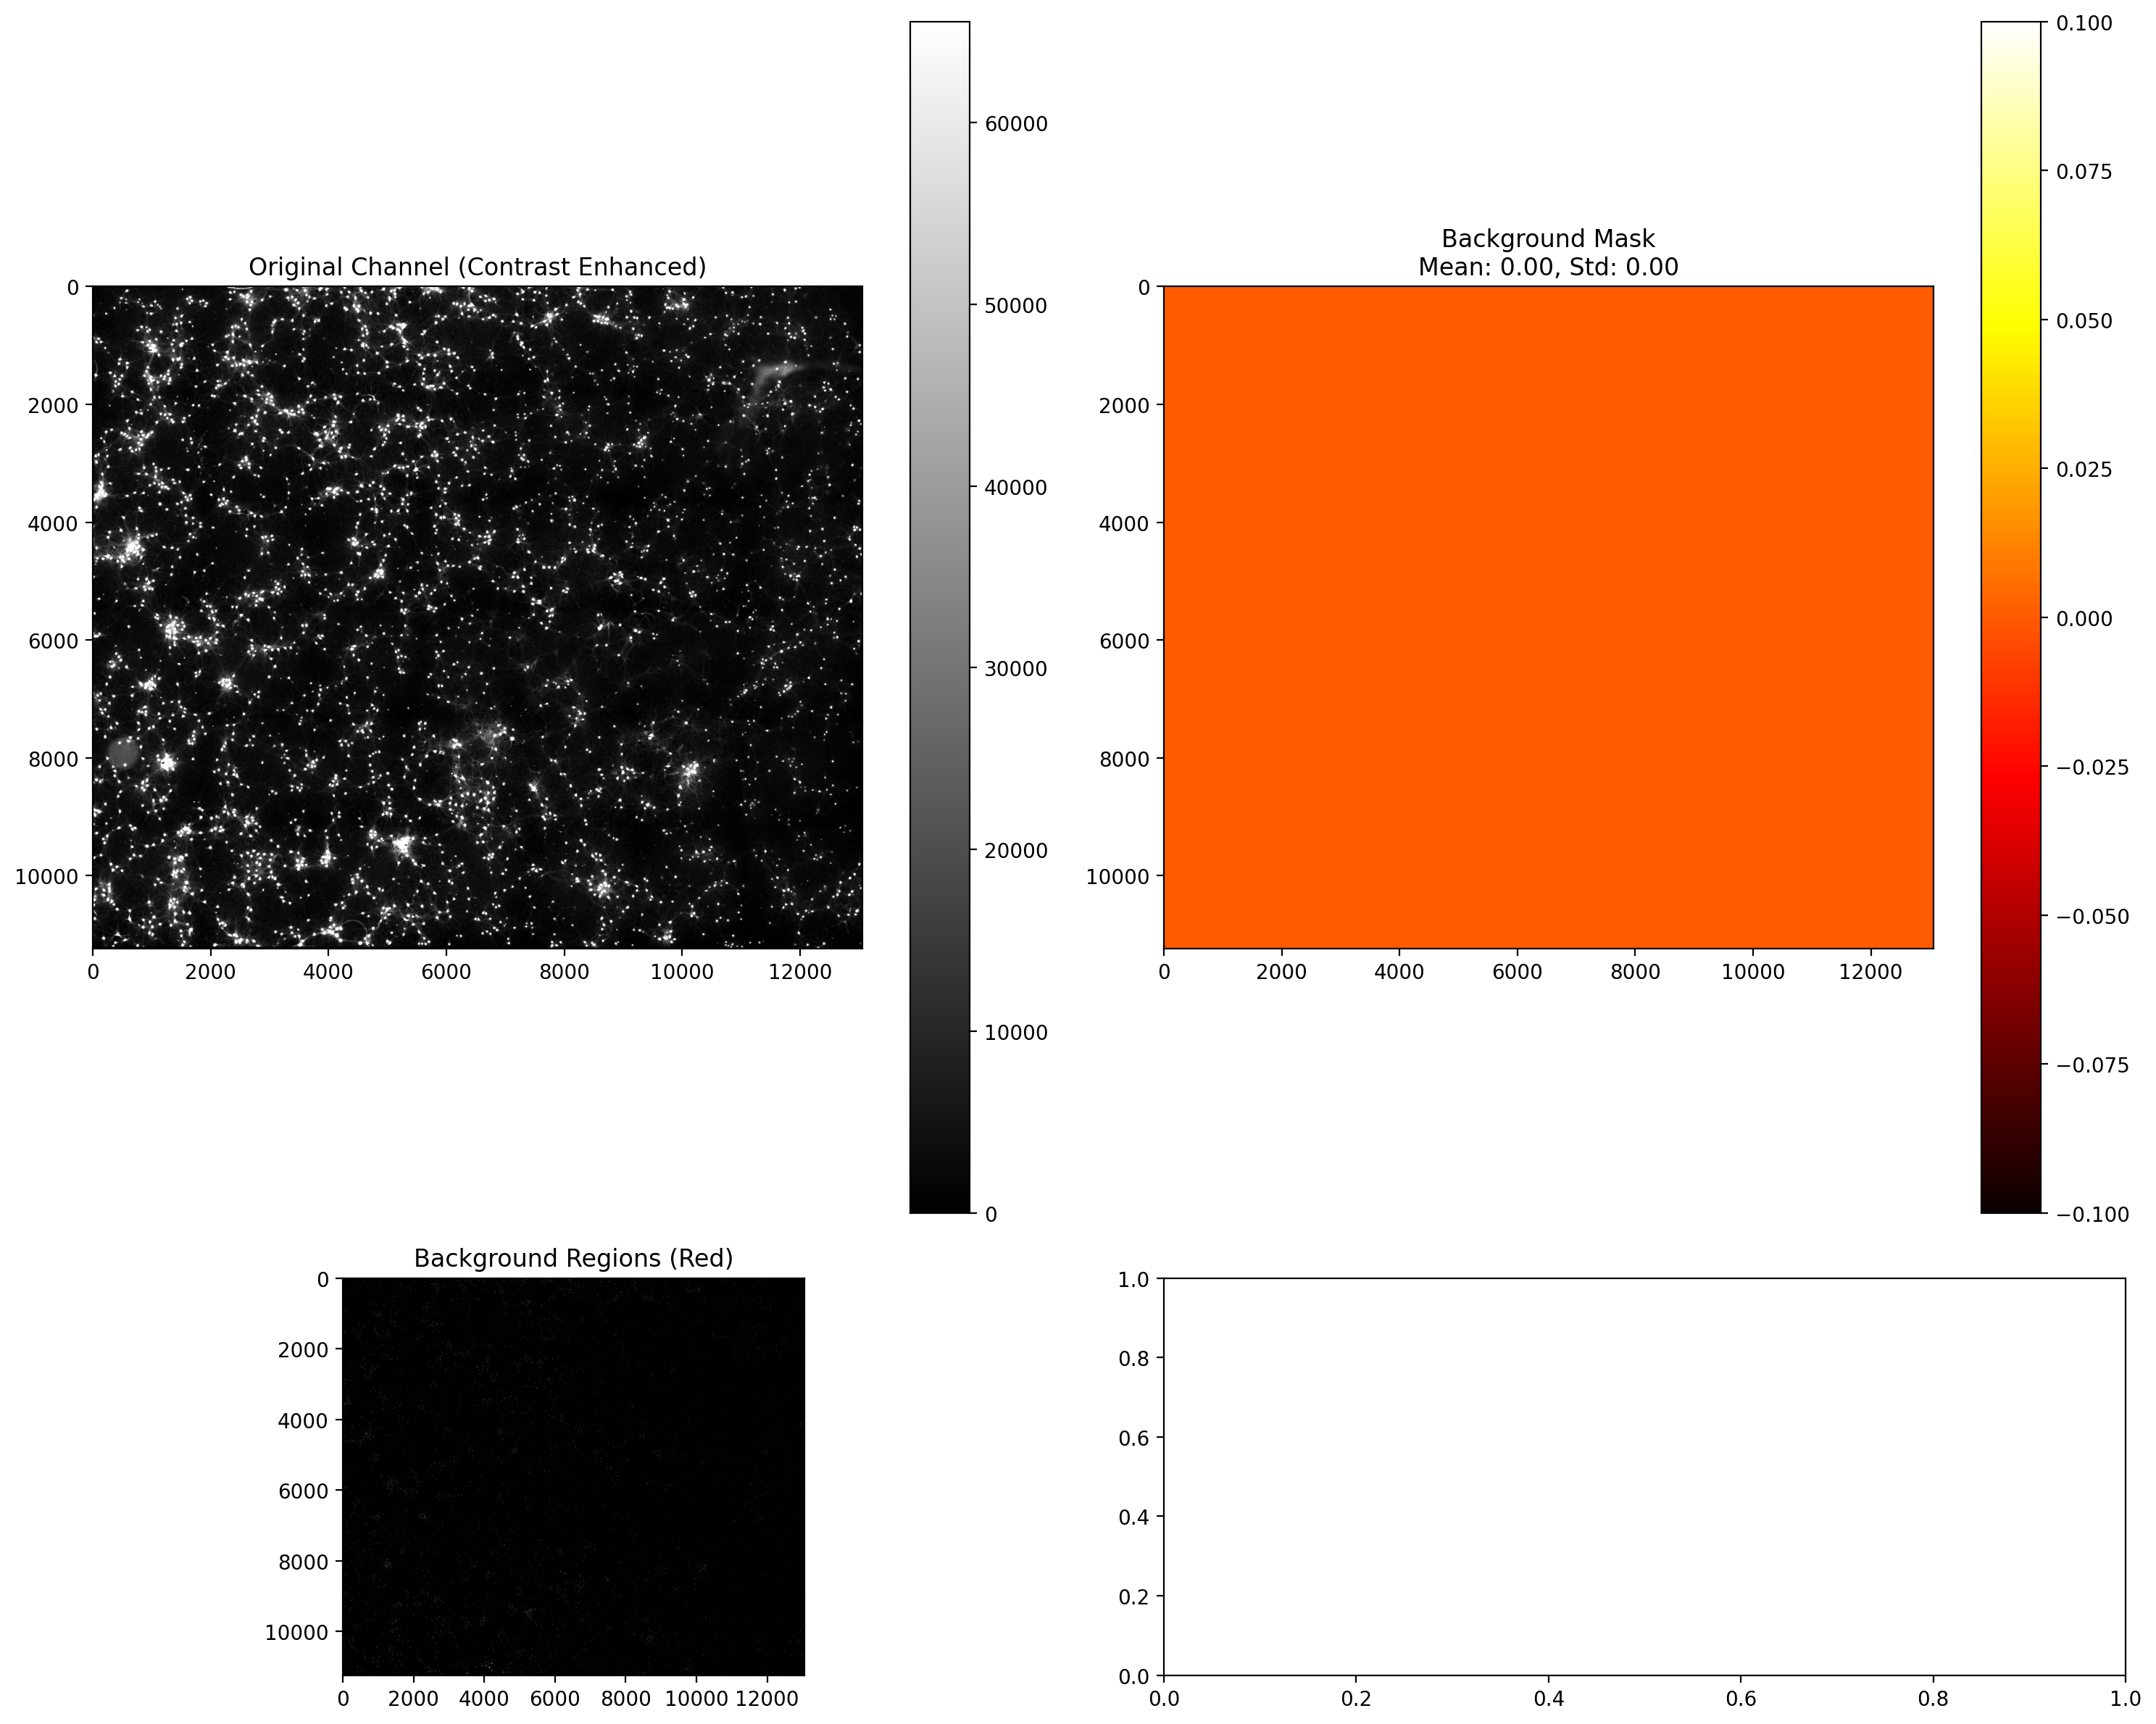

In [10]:
# Process all experiments in the selected folder
batch_results = process_experiments_batch(batch_folder, config)
print(f'>>> Batch processing complete. Results saved to: {batch_results}')